# 🔧 1. Preprocess the Image


I OR 1

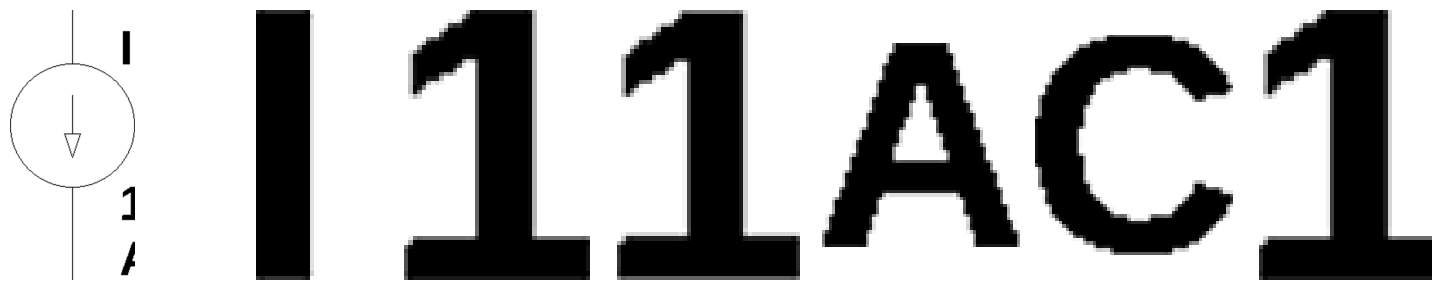

[['None'], ['I', '1'], ['1'], ['None', 'None', '1']]
--- 0.136580228805542 seconds ---


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
start_time = time.time()



# Load and preprocess image
image_path = "ex_cir.png"
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours and extract bounding boxes
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# Group bounding boxes into lines by y-coordinate
line_threshold = 15
lines = []
for box in bounding_boxes:
    x, y, w, h = box
    for line in lines:
        if abs(line[0][1] - y) < line_threshold:
            line.append(box)
            break
    else:
        lines.append([box])

# Sort lines by y, and each line by x
lines = sorted(lines, key=lambda l: l[0][1])
for line in lines:
    line.sort(key=lambda box: box[0])
sorted_boxes = [box for line in lines for box in line]

# Extract and classify character images
def classify_character(img):
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    h, w = binary.shape
    if w == 0:
        return "None"
    aspect_ratio = h / float(w)
    horizontal_sum = np.sum(binary, axis=1)
    top = horizontal_sum[:10].mean()
    bottom = horizontal_sum[-10:].mean()

    if aspect_ratio > 1.7 and bottom > top * 0.9 and bottom < top * 1.1:
        return "I"
    elif 1.3 < aspect_ratio < 1.7 and bottom > top * 1.2:
        return "1"
    return "None"

# Display character crops
char_images = []
for x, y, w, h in sorted_boxes:
    if h > 10 and w > 5:
        char_crop = gray[y:y+h, x:x+w]
        char_images.append(char_crop)

fig, axs = plt.subplots(1, len(char_images), figsize=(15, 3))
for i, char_img in enumerate(char_images):
    axs[i].imshow(char_img, cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Group bounding boxes into lines again for grouped results
grouped_lines = []
for box in sorted_boxes:
    x, y, w, h = box
    for line in grouped_lines:
        if abs(line[0][1] - y) < line_threshold:
            line.append((x, y, w, h))
            break
    else:
        grouped_lines.append([(x, y, w, h)])

# Sort each line and classify characters
grouped_results = []
for line in grouped_lines:
    line.sort(key=lambda b: b[0])
    line_result = []
    for x, y, w, h in line:
        if h > 10 and w > 5:
            char_crop = gray[y:y+h, x:x+w]
            classification = classify_character(char_crop)
            line_result.append(classification)
    grouped_results.append(line_result)

# Output grouped classification results
print(grouped_results)
print("--- %s seconds ---" % (time.time() - start_time))
